In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 4.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale
from sklearn.utils import check_random_state
from sklearn.utils.fixes import _astype_copy_false
from sklearn.utils.validation import check_array, check_X_y
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.multiclass import check_classification_targets
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from scipy import special, stats
from scipy.sparse import issparse
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import (as_float_array, check_array, check_X_y, safe_sqr,safe_mask)
from sklearn.utils.extmath import safe_sparse_dot, row_norms
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.feature_selection._base import SelectorMixin
from sklearn.metrics import roc_auc_score
from scipy.sparse import issparse
from scipy.special import digamma
import scipy.stats as stats
from subprocess import check_output
from math import log
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
def contingency_matrix(labels_true, labels_pred, *, eps=None, sparse=False):
    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            contingency = contingency + eps
    return contingency

In [ ]:

def check_clusterings(labels_true, labels_pred):
    labels_true = check_array(
        labels_true, ensure_2d=False, ensure_min_samples=0, dtype=None,
    )
    labels_pred = check_array(
        labels_pred, ensure_2d=False, ensure_min_samples=0, dtype=None,
    )

    # input checks
    if labels_true.ndim != 1:
        raise ValueError(
            "labels_true must be 1D: shape is %r" % (labels_true.shape,))
    if labels_pred.ndim != 1:
        raise ValueError(
            "labels_pred must be 1D: shape is %r" % (labels_pred.shape,))
    check_consistent_length(labels_true, labels_pred)

    return labels_true, labels_pred

In [ ]:
#importing dataset
df = pd.read_csv('lung.tab', delimiter='\t')
df.shape

(205, 12601)

In [ ]:
df.head()

,class,38691_s_at,37864_s_at,33273_f_at,33274_f_at,33501_r_at,33500_i_at,33499_s_at,41164_at,38194_s_at,37004_at,40808_at,41827_f_at,34105_f_at,41165_g_at,769_s_at,33699_at,31444_s_at,33383_f_at,37039_at,32052_at,32805_at,34301_r_at,33322_i_at,35566_f_at,35083_at,33377_at,34342_s_at,32252_at,36780_at,31687_f_at,37383_f_at,39248_at,34485_r_at,AFFX,35905_s_at,676_g_at,35530_f_at,39026_r_at,41237_at,...,31760_at,31880_at,38383_at,475_at,1245_i_at,34096_at,33793_at,37112_at,36258_at,37090_at,38879_at,41334_r_at,35681_r_at,876_at,34938_i_at,37524_at,AFFX-TrpnX-M_at,32037_r_at,32301_at,32075_at,38525_at,35894_at,35259_s_at,34544_at,39742_at,32083_at,AFFX-CreX-5_at,38911_at,33628_g_at,32012_at,41848_f_at,32086_at,33886_at,31781_at,AFFX-BioC-3_at,41422_at,39964_at,36120_at,40571_at,36312_at
0,discrete,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,...,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous
1,class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AD,63.2,4196.25,3306.35,3330.86,1609.47,1597.32,1233.89,255.14,3036.53,8.92,16.21,1562.5,665.35,135.43,2397.58,98.89,2290.93,-4.03,1402.85,54.28,50.23,239.64,852.82,499.25,4182.14,-8.08,1887.45,0.01,559.25,114.31,4261.15,59.96,-414.3,2565.55,5090.71,4751.66,266.57,126.5,2528.43,...,-8.08,10.54,12.16,18.63,6.49,-2.41,-11.32,5.68,15.4,-9.7,-4.84,22.68,14.59,4.87,-6.46,4.87,-33.16,3.25,0.01,10.54,-5.65,-21.83,34.02,17.02,35.64,13.78,-22.64,6.49,-15.36,2.44,-17.79,18.63,51.04,-13.74,-29.12,-28.31,20.25,28.35,4.06,-19.41
3,AD,965.47,6207.61,7077.04,6968.59,6569.86,6419.19,6908.34,4785.76,4562.19,1120.1,31.42,4152.27,4600.01,3480.65,2534.08,84.5,2141,234.08,2577.81,67.52,1723.45,78.13,433.87,3352.11,4389.94,30.36,1061.32,18.68,894.66,32.48,3910.93,1808.95,14.43,2362.42,4509.08,3496.16,3523.09,-2.56,2127.27,...,0.63,21.86,11.24,22.92,17.61,0.63,-4.68,9.12,17.61,2.75,-1.5,20.8,20.8,18.68,-2.56,13.37,-7.87,14.43,10.18,26.11,13.37,9.12,27.17,22.92,27.17,20.8,-14.24,16.55,-6.81,11.24,-5.74,5.94,28.23,-4.68,-13.18,-13.18,21.86,9.12,11.24,8.06
4,AD,2940.51,6858.12,6927.79,6495.99,5273.47,4672.48,5474.67,2140.99,5120.39,1212.9,-0.195,3623.89,1533.9,1187.76,3105.11,65.925,2784.31,476.26,2471.1,216.965,2565.11,278.155,819.1,1030.22,4743.8,16.71,1553.85,-1.125,797.565,101.705,3264.08,2372.18,-67.92,1861.83,5321.86,3302.88,1185.65,17.02,2027.95,...,-10.695,11.57,2.92,0.885,-0.81,-3.16,-14.575,-1.575,10.745,-9.295,2.47,20.535,10.815,2.735,-3.475,7.61,-25.205,5.175,0.995,22.235,1.28,-15.93,9.96,6.71,26.31,8.32,-19.73,9.905,-2.915,-0.25,-17.225,4.725,17.28,-6.59,-17.97,-16.07,10.195,17.285,6.92,-11.09


In [ ]:
df=df.dropna().loc[1:,:]

In [ ]:
X = df.drop(['class '], axis=1)
X.head()

,38691_s_at,37864_s_at,33273_f_at,33274_f_at,33501_r_at,33500_i_at,33499_s_at,41164_at,38194_s_at,37004_at,40808_at,41827_f_at,34105_f_at,41165_g_at,769_s_at,33699_at,31444_s_at,33383_f_at,37039_at,32052_at,32805_at,34301_r_at,33322_i_at,35566_f_at,35083_at,33377_at,34342_s_at,32252_at,36780_at,31687_f_at,37383_f_at,39248_at,34485_r_at,AFFX,35905_s_at,676_g_at,35530_f_at,39026_r_at,41237_at,AFFX-HUMGAPDH/M33197_5_at,...,31760_at,31880_at,38383_at,475_at,1245_i_at,34096_at,33793_at,37112_at,36258_at,37090_at,38879_at,41334_r_at,35681_r_at,876_at,34938_i_at,37524_at,AFFX-TrpnX-M_at,32037_r_at,32301_at,32075_at,38525_at,35894_at,35259_s_at,34544_at,39742_at,32083_at,AFFX-CreX-5_at,38911_at,33628_g_at,32012_at,41848_f_at,32086_at,33886_at,31781_at,AFFX-BioC-3_at,41422_at,39964_at,36120_at,40571_at,36312_at
2,63.2,4196.25,3306.35,3330.86,1609.47,1597.32,1233.89,255.14,3036.53,8.92,16.21,1562.5,665.35,135.43,2397.58,98.89,2290.93,-4.03,1402.85,54.28,50.23,239.64,852.82,499.25,4182.14,-8.08,1887.45,0.01,559.25,114.31,4261.15,59.96,-414.3,2565.55,5090.71,4751.66,266.57,126.5,2528.43,2570.5,...,-8.08,10.54,12.16,18.63,6.49,-2.41,-11.32,5.68,15.4,-9.7,-4.84,22.68,14.59,4.87,-6.46,4.87,-33.16,3.25,0.01,10.54,-5.65,-21.83,34.02,17.02,35.64,13.78,-22.64,6.49,-15.36,2.44,-17.79,18.63,51.04,-13.74,-29.12,-28.31,20.25,28.35,4.06,-19.41
3,965.47,6207.61,7077.04,6968.59,6569.86,6419.19,6908.34,4785.76,4562.19,1120.1,31.42,4152.27,4600.01,3480.65,2534.08,84.5,2141,234.08,2577.81,67.52,1723.45,78.13,433.87,3352.11,4389.94,30.36,1061.32,18.68,894.66,32.48,3910.93,1808.95,14.43,2362.42,4509.08,3496.16,3523.09,-2.56,2127.27,2402.53,...,0.63,21.86,11.24,22.92,17.61,0.63,-4.68,9.12,17.61,2.75,-1.5,20.8,20.8,18.68,-2.56,13.37,-7.87,14.43,10.18,26.11,13.37,9.12,27.17,22.92,27.17,20.8,-14.24,16.55,-6.81,11.24,-5.74,5.94,28.23,-4.68,-13.18,-13.18,21.86,9.12,11.24,8.06
4,2940.51,6858.12,6927.79,6495.99,5273.47,4672.48,5474.67,2140.99,5120.39,1212.9,-0.195,3623.89,1533.9,1187.76,3105.11,65.925,2784.31,476.26,2471.1,216.965,2565.11,278.155,819.1,1030.22,4743.8,16.71,1553.85,-1.125,797.565,101.705,3264.08,2372.18,-67.92,1861.83,5321.86,3302.88,1185.65,17.02,2027.95,1594.8,...,-10.695,11.57,2.92,0.885,-0.81,-3.16,-14.575,-1.575,10.745,-9.295,2.47,20.535,10.815,2.735,-3.475,7.61,-25.205,5.175,0.995,22.235,1.28,-15.93,9.96,6.71,26.31,8.32,-19.73,9.905,-2.915,-0.25,-17.225,4.725,17.28,-6.59,-17.97,-16.07,10.195,17.285,6.92,-11.09
5,64.07,7016.91,7132.05,6983.44,6284.96,5504.68,6097.27,5885.41,5446.04,4422.72,-11.14,4812.18,3995.36,4282.76,2003.31,530.195,1914.52,1843.67,2398,251.77,392.635,186.3,804.645,3541.65,4335.57,34.69,880.48,-7.115,305.48,100.605,3880.54,926.18,-275.715,2340.89,5010.51,2895.65,4073.99,14.22,3546.41,1937.18,...,-10.9,18.805,16.37,36.22,10.455,2.435,-4.52,13.895,12.29,-5.52,-7.52,9.915,15.845,9.915,-5.065,18.285,-15.445,11.395,-6.01,28.765,1.49,0.95,26.325,18.905,29.67,17.875,-7.555,17.29,-20.015,8.415,-10.525,11.93,38.755,-5.005,-21.445,-24.335,14.355,39.2,12.335,7.41
6,3451.94,6281.06,6650.54,6858.68,6007.37,5517.95,5729.06,3245.64,5717.88,4116.73,-8.06,3387.26,3122.34,2268.38,2882.63,281.93,2860.16,1748.75,3219.15,314.15,30.42,41.56,785.17,2513.71,5308.86,11.18,542.78,-24.27,442.72,126.53,4939.59,605.62,365.43,2317.04,4614.94,3636.69,1939.55,0.04,3158.3,2503.9,...,-13.13,9.16,-1.98,21.31,-4.01,-4.01,-13.13,0.04,2.07,-4.01,-13.13,2.07,10.17,-6.03,-13.13,0.04,-25.28,-1.98,-1.98,7.13,0.04,-19.2,14.22,16.25,20.3,11.18,-30.35,-0.97,-6.03,-10.09,-11.1,-12.11,32.45,-16.17,-13.13,-18.19,11.18,14.22,5.11,-8.06


In [ ]:
# Mapping classes into integers
y = df['class ']
y=y.map({'AD ': 1, 'NL ': 0,'SMCL ':2,'SQ ':3,'COID ':4})
y.head()

2    1
3    1
4    1
5    1
6    1
Name: class , dtype: int64

In [ ]:
df.dtypes

class          object
38691_s_at     object
37864_s_at     object
33273_f_at     object
33274_f_at     object
                ...  
41422_at       object
39964_at       object
36120_at       object
40571_at       object
36312_at       object
Length: 12601, dtype: object

In [ ]:
print(X.shape)
print(y.shape)

(203, 12600)
(203,)


In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((162, 12600), (162,), (41, 12600), (41,))

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)

In [ ]:
X_train_T = X_train_filter.T
X_test_T = X_test_filter.T
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)

In [ ]:
X_train_T.duplicated().sum()

0

In [ ]:
duplicated_features = X_train_T.duplicated()

In [ ]:
features_to_keep = [not index for index in duplicated_features]
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T
X_train_unique.shape, X_test_unique.shape

((162, 12600), (41, 12600))

In [ ]:
#Function for KNN Classifier C1
from sklearn.metrics import jaccard_score #for multiclass classification accuracy score are equivalent to jaccard score.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix
def run_knn(X_train, X_test, y_train, y_test):
    c1 =KNeighborsClassifier(n_neighbors=3)
    c1.fit(X_train, y_train)
    y_pred = c1.predict(X_train)
    y_test_pred=c1.predict(X_test)
    print('Training 80% data report::')
    print('Accuracy Score: ')
    print(jaccard_score(y_train, y_pred,average="weighted"))
    print('F1-Score: ')
    print(f1_score(y_train, y_pred,average="weighted"))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_train, y_pred))
    print('Testing 20% data report::')
    print('Accuracy Score: ')
    print(jaccard_score(y_test, y_test_pred,average="weighted"))
    print('F1-Score: ')
    print(f1_score(y_test, y_test_pred,average="weighted"))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_test_pred))


In [ ]:
#Function for SVM Classifier C2
def run_svm(X_train, X_test, y_train, y_test):
    c2 =svm.SVC()
    c2.fit(X_train, y_train)
    y_pred = c2.predict(X_train)
    y_test_pred=c2.predict(X_test)
    print('Training 80% data report::')
    print('Accuracy Score: ')
    print(jaccard_score(y_train, y_pred,average="weighted"))
    print('F1-Score: ')
    print(f1_score(y_train, y_pred,average="weighted"))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_train, y_pred))
    print('Testing 20% data report::')
    print('Accuracy Score: ')
    print(jaccard_score(y_test, y_test_pred,average="weighted"))
    print('F1-Score: ')
    print(f1_score(y_test, y_test_pred,average="weighted"))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_test_pred))


## Classification without feature selection

In [ ]:
%%time
run_knn(X_train_unique, X_test_unique, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9173105091184187
F1-Score: 
0.9560344204327708
Confusion Matrix: 
[[ 11   0   0   0   0]
 [  2 111   0   0   0]
 [  0   1   3   0   0]
 [  0   3   0  12   0]
 [  0   1   0   0  18]]
Testing 20% data report::
Accuracy Score: 
0.9059233449477351
F1-Score: 
0.9472448057813911
Confusion Matrix: 
[[ 6  0  0  0  0]
 [ 0 26  0  0  0]
 [ 0  0  2  0  0]
 [ 0  2  0  4  0]
 [ 0  0  0  0  1]]
CPU times: user 1.4 s, sys: 3.02 ms, total: 1.41 s
Wall time: 1.41 s


In [ ]:
%%time
run_svm(X_train_unique, X_test_unique, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.8589629629629629
F1-Score: 
0.9108048410880656
Confusion Matrix: 
[[  7   4   0   0   0]
 [  0 113   0   0   0]
 [  0   4   0   0   0]
 [  0   4   0  11   0]
 [  0   0   0   0  19]]
Testing 20% data report::
Accuracy Score: 
0.6174216027874565
F1-Score: 
0.7238590278174445
Confusion Matrix: 
[[ 4  2  0  0  0]
 [ 0 26  0  0  0]
 [ 0  2  0  0  0]
 [ 0  5  0  1  0]
 [ 0  0  0  0  1]]
CPU times: user 1.28 s, sys: 5.07 ms, total: 1.28 s
Wall time: 1.28 s


## Task A.1: Application of Mutual Information based feature selection(f1)

In [ ]:
# Functions of Mutual information

def mutual_info_score(labels_true, labels_pred, *, contingency=None):
    if contingency is None:
        labels_true, labels_pred = check_clusterings(labels_true, labels_pred)
        contingency = contingency_matrix(labels_true, labels_pred, sparse=True)
    else:
        contingency = check_array(contingency,
                                  accept_sparse=['csr', 'csc', 'coo'],
                                  dtype=[int, np.int32, np.int64])
    if isinstance(contingency, np.ndarray):
        nzx, nzy = np.nonzero(contingency)
        nz_val = contingency[nzx, nzy]
    elif sp.issparse(contingency):
        nzx, nzy, nz_val = sp.find(contingency)

    contingency_sum = contingency.sum()
    pi = np.ravel(contingency.sum(axis=1))
    pj = np.ravel(contingency.sum(axis=0))
    log_contingency_nm = np.log(nz_val)
    contingency_nm = nz_val / contingency_sum
    outer = (pi.take(nzx).astype(np.int64, copy=False)
             * pj.take(nzy).astype(np.int64, copy=False))
    log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
    mi = (contingency_nm * (log_contingency_nm - log(contingency_sum)) +
          contingency_nm * log_outer)
    return np.clip(mi.sum(), 0.0, None)

In [ ]:
#driver code
def _compute_mi(x, y, n_neighbors=3):
        return mutual_info_score(x, y)

def _iterate_columns(X, columns=None):
    if columns is None:
        columns = range(X.shape[1])

    if issparse(X):
        for i in columns:
            x = np.zeros(X.shape[0])
            start_ptr, end_ptr = X.indptr[i], X.indptr[i + 1]
            x[X.indices[start_ptr:end_ptr]] = X.data[start_ptr:end_ptr]
            yield x
    else:
        for i in columns:
            yield X[:, i]


def _estimate_mi(X, y,n_neighbors=3):
    X, y = check_X_y(X, y, accept_sparse='csc')
    n_samples, n_features = X.shape
    discrete_features = issparse(X)
    discrete_mask = np.empty(n_features, dtype=bool)
    discrete_mask.fill(discrete_features)
    
    mi = [_compute_mi(x, y, n_neighbors) for
          x, discrete_feature in zip(_iterate_columns(X), discrete_mask)]

    return np.array(mi)

def mutual_info_classifier(X, y, n_neighbors=3,):
    check_classification_targets(y)
    return _estimate_mi(X, y, n_neighbors)

In [ ]:
mi = mutual_info_classifier(X_train_unique, y_train) 
len(mi)

12600

In [ ]:
mi[: 10]

array([0.99696706, 0.99696706, 0.99696706, 0.99696706, 0.99696706,
       0.99696706, 0.99696706, 0.99696706, 0.99696706, 0.99696706])

In [ ]:
mi = pd.Series(mi)
mi.index = X_train_unique.columns

In [ ]:
mi.sort_values(ascending=False, inplace = True)

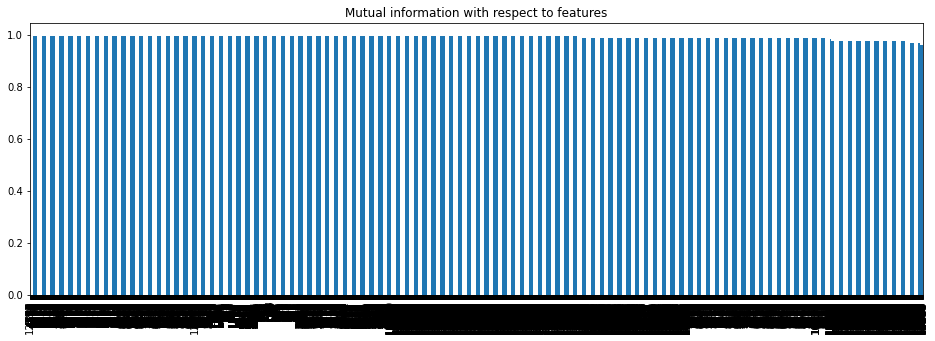

In [ ]:
plt.title('Mutual information with respect to features')
mi.plot.bar(figsize = (16,5))
plt.show()

In [ ]:
sel = SelectPercentile(mutual_info_classifier, percentile=10).fit(X_train_unique, y_train)
X_train_unique.columns[sel.get_support()]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1490, 1491, 1492, 1494, 1495, 1496, 1497, 1498, 1499, 1500],
           dtype='int64', length=1260)

In [ ]:
len(X_train_unique.columns[sel.get_support()])

1260

In [ ]:
X_train_mi = sel.transform(X_train_unique)
X_test_mi = sel.transform(X_test_unique)
X_train_mi.shape

(162, 1260)

## Application Of KNN with 3 neighbors(C1)

In [ ]:
%%time
run_knn(X_train_mi, X_test_mi, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9046296296296297
F1-Score: 
0.9473496805664056
Confusion Matrix: 
[[ 11   0   0   0   0]
 [  1 112   0   0   0]
 [  0   2   2   0   0]
 [  0   4   0  11   0]
 [  0   1   0   0  18]]
Testing 20% data report::
Accuracy Score: 
0.8612279226240538
F1-Score: 
0.9166297117516629
Confusion Matrix: 
[[ 6  0  0  0  0]
 [ 0 26  0  0  0]
 [ 0  0  2  0  0]
 [ 0  3  0  3  0]
 [ 0  0  0  0  1]]
CPU times: user 138 ms, sys: 2.1 ms, total: 140 ms
Wall time: 137 ms


## Application Of SVM (C2)



In [ ]:
%%time
run_svm(X_train_mi, X_test_mi, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.8492674897119341
F1-Score: 
0.9049486898994634
Confusion Matrix: 
[[  8   3   0   0   0]
 [  1 112   0   0   0]
 [  0   4   0   0   0]
 [  0   5   0  10   0]
 [  0   0   0   0  19]]
Testing 20% data report::
Accuracy Score: 
0.6556671449067432
F1-Score: 
0.7488332805405976
Confusion Matrix: 
[[ 5  1  0  0  0]
 [ 0 26  0  0  0]
 [ 0  2  0  0  0]
 [ 0  5  0  1  0]
 [ 0  0  0  0  1]]
CPU times: user 155 ms, sys: 2.09 ms, total: 157 ms
Wall time: 155 ms


## Task A.2: Application of F Classifier based feature selection(f2)

In [ ]:
#Functions for F classifier 
def f_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    constant_features_idx = np.where(msw == 0.)[0]
    f = msb / msw #High variance upon low variance 
    # flatten matrix to vector in sparse case
    f = np.asarray(f).ravel()
    prob = special.fdtrc(dfbn, dfwn, f)
    return f, prob


def f_classif(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return f_oneway(*args)

In [ ]:
fc= f_classif(X_train, y_train) 
len(mi)

12600

In [ ]:
fc[: 10]

(array([20.45594579, 19.77026585, 19.0015463 , ...,  2.86854296,
         5.14358034,  2.87741119]),
 array([1.39495319e-13, 3.37997015e-13, 9.22075653e-13, ...,
        2.49908230e-02, 6.39583549e-04, 2.46408466e-02]))

In [ ]:
#from sklearn.feature_selection import chi2, f_classif
fvalue_selector = SelectPercentile(f_classif, percentile = 10)

In [ ]:
features_kbest = fvalue_selector.fit_transform(X_train_unique, y_train)

In [ ]:
X_train_fc = fvalue_selector.transform(X_train_unique)
X_test_fc = fvalue_selector.transform(X_test_unique)
X_train_fc.shape

(162, 1260)

## Application Of KNN (C1)

In [ ]:
%%time
run_knn(X_train_fc, X_test_fc, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9411274301121045
F1-Score: 
0.9684561432310904
Confusion Matrix: 
[[ 11   0   0   0   0]
 [  1 111   0   1   0]
 [  0   0   4   0   0]
 [  0   3   0  12   0]
 [  0   0   0   0  19]]
Testing 20% data report::
Accuracy Score: 
0.7483421377992582
F1-Score: 
0.8374511667194593
Confusion Matrix: 
[[ 5  1  0  0  0]
 [ 0 25  0  1  0]
 [ 0  0  2  0  0]
 [ 0  4  0  2  0]
 [ 0  0  0  0  1]]
CPU times: user 142 ms, sys: 1.03 ms, total: 143 ms
Wall time: 145 ms


## Application Of SVM (C2)

In [ ]:
%%time
run_svm(X_train_fc, X_test_fc, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9280096951942527
F1-Score: 
0.9574227436546278
Confusion Matrix: 
[[ 11   0   0   0   0]
 [  1 112   0   0   0]
 [  0   3   1   0   0]
 [  0   2   0  13   0]
 [  0   0   0   0  19]]
Testing 20% data report::
Accuracy Score: 
0.668567205152571
F1-Score: 
0.7691464688941559
Confusion Matrix: 
[[ 5  1  0  0  0]
 [ 0 25  0  1  0]
 [ 0  2  0  0  0]
 [ 0  4  0  2  0]
 [ 0  0  0  0  1]]
CPU times: user 133 ms, sys: 3.01 ms, total: 136 ms
Wall time: 138 ms


## Task A.3: Application of T test based feature selection(f3)

In [ ]:
#Functions for  t-test 
import math
def t_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    constant_features_idx = np.where(msw == 0.)[0]
    t = (ssbn-sswn)**2/ (msb+msw) #Taking sqrt of t value instead of absolute as t due to limitation of numpy. t^2= (absolute differences of means/sum of variances)^2
    # flatten matrix to vector in sparse case
    t = np.asarray(t).ravel()
    prob = special.fdtrc(dfbn, dfwn, t)
    return t, prob


def t_test(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return t_oneway(*args)

In [ ]:
tt= t_test(X_train, y_train) 
len(tt)

2

In [ ]:
tt[: 10]

(array([1.05926799e+09, 1.12558279e+09, 1.24804079e+09, ...,
        1.37473553e+06, 6.80511693e+05, 1.27942363e+06]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
#from sklearn.feature_selection import chi2, f_classif
tvalue_selector = SelectPercentile(t_test, percentile = 10)

In [ ]:
featurestt_kbest = tvalue_selector.fit_transform(X_train_unique, y_train)

In [ ]:
X_train_t = tvalue_selector.transform(X_train_unique)
X_test_t = tvalue_selector.transform(X_test_unique)
X_train_t.shape

(162, 1260)

## Application Of KNN (C1)

In [ ]:
%%time
run_knn(X_train_t, X_test_t, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.8961070382327444
F1-Score: 
0.9398138893077388
Confusion Matrix: 
[[ 11   0   0   0   0]
 [  2 110   0   1   0]
 [  1   2   1   0   0]
 [  0   2   0  13   0]
 [  0   1   0   0  18]]
Testing 20% data report::
Accuracy Score: 
0.9059233449477351
F1-Score: 
0.9469491664613616
Confusion Matrix: 
[[ 6  0  0  0  0]
 [ 0 26  0  0  0]
 [ 0  1  1  0  0]
 [ 0  1  0  5  0]
 [ 0  0  0  0  1]]
CPU times: user 142 ms, sys: 3.95 ms, total: 146 ms
Wall time: 143 ms


## Application Of SVM (C2)

In [ ]:
%%time
run_svm(X_train_t, X_test_t, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.8256655092592593
F1-Score: 
0.8887747584049758
Confusion Matrix: 
[[  6   5   0   0   0]
 [  0 113   0   0   0]
 [  0   4   0   0   0]
 [  0   6   0   9   0]
 [  0   0   0   0  19]]
Testing 20% data report::
Accuracy Score: 
0.5799457994579946
F1-Score: 
0.6956277396875351
Confusion Matrix: 
[[ 3  3  0  0  0]
 [ 0 26  0  0  0]
 [ 0  2  0  0  0]
 [ 0  5  0  1  0]
 [ 0  0  0  0  1]]
CPU times: user 153 ms, sys: 3.99 ms, total: 157 ms
Wall time: 158 ms


### End of Task A